# Students Do: Housing Price Prediction on SageMaker

* **Dataset:** [Boston house prices dataset - Harrison, D. and Rubinfeld, D.L.](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)
* **Goal:** Predict the price of a house using linear regression given certain input features.

**Note:** You should import and run this notebook into your notebook instance on Amazon SageMaker.

In [33]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the Boston House Price Data from `sklearn`

In [34]:
# Loading the Boston house price data from sklearn
from sklearn.datasets import load_boston

boston_dataset = load_boston()

In [35]:
dir(boston_dataset)

['DESCR', 'data', 'feature_names', 'filename', 'target']

In [36]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [37]:
# Creating a DataFrame with the Boston House Data features
features_df = pd.DataFrame(boston_dataset.data, 
                           columns=boston_dataset.feature_names)

features_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [38]:
# Creating a DataFrame with the target data
target_df = pd.DataFrame(boston_dataset.target)
                         #columns=["MEDV"])

target_df.head()

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


<AxesSubplot:ylabel='Frequency'>

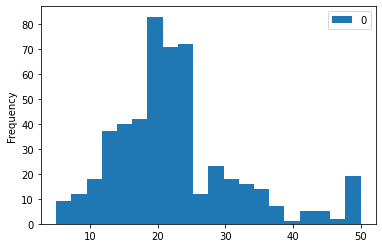

In [39]:
# Plot target distribution
target_df.plot.hist(bins=20)

## Data Preparation

A linear regression model will be trained using the average number of rooms per dwelling (`RM`) to predict the house price.

* `X` is the predictor variable vector with the values of `RM`.
* `Y` is the target variable vector with the house prices value.

In [51]:
# Define the X and Y vectors
X = features_df[["RM"]].values.reshape(-1, 1)

Y = boston_dataset.target

# Split the data in training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2)

## Machine Learning Model Creation

In [52]:
bucket = "fintechweek13day2"
prefix = "boston-housing-regression"

# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import get_execution_role
import boto3  # AWS Python sdk

import os
import io
import time
import json
import re

# AWS IAM role
role = get_execution_role()

### Uploading Training Data to Amazon S3

In order to train your machine learning model using Amazon SageMaker, the training data should passed through an Amazon S3 Bucket formatted as a [protobuf recordIO format](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html#td-serialization).

The profobuf recordIO format, is a method to serialize structured data (similar to `JSON`), to allow different applications to communicate with each other or for storing data.

Using the profobuf recordIO format, allows you to take advantage of _Pipe mode_ when training the algorithms that support it. In _Pipe mode_, your training job streams data directly from Amazon S3. Streaming can provide faster start times for training jobs and better throughput.

The following code converts the training data as a Protocol Buffer, next the data is uploaded to the Amazon S3 bucket.

In [57]:
# Encode the training data as Protocol Buffer
buf = io.BytesIO()

vectors = np.array(X_train).astype("float32")

labels = np.array(y_train).astype("float32")

smac.write_numpy_to_dense_tensor(buf,
                                 vectors,
                                 labels)

buf.seek(0)

# Upload encoded training data to Amazon S3
key = "linear_train.data"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
                                                                                              
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
                                                                                              
print(f"Training data uploaded to: {s3_train_data}")

Training data uploaded to: s3://fintechweek13day2/boston-housing-regression/train/linear_train.data


#### Upload Test Data to Amazon S3

If you provide test data, the algorithm logs include the test score for the final model.

In [58]:
# Encode the training data as Protocol Buffer
buf = io.BytesIO()

vectors = np.array(X_test).astype("float32")

labels = np.array(y_test).astype("float32")

smac.write_numpy_to_dense_tensor(buf,
                                 vectors,
                                 labels)

buf.seek(0)

# Upload encoded training data to Amazon S3
key = "linear_test.data"

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "test", key)).upload_fileobj(buf)
                                                                                              
s3_test_data = f"s3://{bucket}/{prefix}/test/{key}"
                                                                                              
print(f"Training data uploaded to: {s3_test_data}")

Training data uploaded to: s3://fintechweek13day2/boston-housing-regression/test/linear_test.data


### Training the Machine Learning Model

Once you have uploaded your data to Amazon S3, it's time to train the machine learning model. In this activity, you will use the Amazon SageMaker's [_linear learner algorithm_](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) to run a linear regression prediction model.

You can learn more about the different Amazon SageMaker built-in algorithms [in this page](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html).

First, an instance of the linear learner algorithm is created.

In [59]:
# Create an instance of the linear learner algorithm
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, "linear-learner")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Next, the estimator container is created in an AWS EC2 instance (@ train_instance_type) using a `ml.m4.xlarge`.

**Note:** This step might take a few minutes.

In [60]:
# Start the Amazon SageMaker session
sess = sagemaker.Session()

# Create an instance of the linear learner estimator
linear = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1,
                                       train_instance_type="ml.m4.xlarge",
                                       output_path=f"s3://{bucket}/{prefix}/output",
                                       sagemaker_session=sess)

# Define linear learner hyperparameters
linear.set_hyperparameters(feature_dim=1,
                           mini_batch_size=100,
                           predictor_type="regressor",
                           epochs=10,
                           num_models=32,
                           loss="absolute_loss")

# Fitting the linear learner model with the training data
linear.fit({"train": s3_train_data,
            "test": s3_test_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-08-04 21:37:42 Starting - Starting the training job...
2021-08-04 21:37:43 Starting - Launching requested ML instancesProfilerReport-1628113062: InProgress
......
2021-08-04 21:39:02 Starting - Preparing the instances for training......
2021-08-04 21:40:05 Downloading - Downloading input data...
2021-08-04 21:40:43 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script

2021-08-04 21:41:06 Uploading - Uploading generated training model[08/04/2021 21:41:00 INFO 139858388674368] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale'

### Deploying the Model to Make Predictions

In this section, the `linear-learner` model that was trained will be used to make predictions of house prices. Deploy the model using a `ml.t2.medium` instance type.

**Note:** This step might take a few minutes.

In [61]:
# An instance of the linear-learner predictor is created
linear_predictor = linear.deploy(initial_instance_count=1, 
                                 instance_type="ml.t2.medium")

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'Number of instances across active endpoints' is 2 Instances, with current utilization of 2 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
# Linear predictor configurations
#linear_predictor.content_type = "text/csv"
linear_predictor.serializer = csv_serializer

linear_predictor.deserializer = json_deserializer

In [ ]:
# Making some predictions using the test data.
result = linear_predictor.predict(X_test)

y_predictions = np.array([r["score"] for r in result["predictions"]])

y_predictions

### Model Evaluation

To evaluate the model, a plot to contrast the predicted housing prices values versus the real values is created. Additionally, the `RMSE` and `R2` scores are calculated.

In [ ]:
# Plotting predicted Vs. actual values
plt.plot(np.array(y_test), label="actual")

plt.plot(y_predictions, label="predict")

plt.legend()

plt.show()

In [ ]:
# Calculating the RMSE and R2 scores
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, 
                                  y_predictions))

r2 = r2_score(y_test, y_predictions)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

Finally the end point is deleted to avoid additional AWS resources usage.

In [ ]:
# Delete Amazon SageMaker end-point
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)